# Part 0:
## import everything
Run the cell below

In [ ]:
# -*- coding: utf-8 -*-
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
from scipy.ndimage.filters import gaussian_filter1d as smooth
import math
import datetime
from copy import deepcopy
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore")
import types
import inspect
import string
import sys, time
import pickle
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import mlab
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import matplotlib.backends.backend_pdf
from sklearn.decomposition import KernelPCA
import mpl_toolkits.axes_grid1.inset_locator as inset
from matplotlib.ticker import FormatStrFormatter
import imageio
from set_rc_params import set_rc_params


if "__file__" not in dir():
    %matplotlib inline
    %config InlineBackend.close_figures = False
    matplotlib.rcdefaults()
    
    if OS()=='Linux':
        root="/data"
    elif OS()=='Windows':
        root="C:\\DATA\\"
    else:
        root="/Users/davidrobbe/Documents/Data/"
            
    ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
    CommonNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
    CWD=os.getcwd()
    os.chdir(CommonNoteBookesPath)
    %run UtilityTools.ipynb
    %run Animal_Tags.ipynb
    %run loadRat_documentation.ipynb
    %run plotRat_documentation_1_GeneralBehavior.ipynb
    %run plotRat_documentation_3_KinematicsInvestigation.ipynb
    %run RunBatchRat_3_CompareGroups.ipynb
    %run BatchRatBehavior.ipynb
    currentNbPath=os.path.join(os.path.split(ThisNoteBookPath)[0],'BehavioralPaper','ShortGT-SharpTrd.ipynb')
    %run $currentNbPath
    os.chdir(CWD)

    logging.getLogger().setLevel(logging.ERROR)
    
    param={
        "goalTime":7,#needed for pavel data only
        "treadmillRange":[0,90],#pavel error conversion "treadmillRange":[0,80]
        "maxTrialDuration":15,
        "interTrialDuration":10,#None pavel
        "endTrial_frontPos":30,
        "endTrial_backPos":55, 
        "endTrial_minTimeSec":4,
        "cameraSamplingRate":25, #needed for new setup    

        "sigmaSmoothPosition":0.1,#0.33, 0.18 pavel
        "sigmaSmoothSpeed":0.3,#0.3, 0.5 pavel
        "nbJumpMax":100,#200 pavel
        "binSize":0.25,
        #parameters used to preprocess (will override the default parameters)
           }  
    Y1,Y2=param['treadmillRange']

    print('os:',OS(),'\nroot:',root,'\nImport successful!')

---
---


# part 1:

# DEFINITIONS

### If you don't know what to do, move to part 2

In [ ]:
def get_ordered_colors(colormap, n):
    colors = []
    cmap = plt.cm.get_cmap(colormap)
    for colorVal in np.linspace(0, 1, n):
        colors.append(cmap(colorVal))
    return colors

In [ ]:
def add_panel_caption(axes: tuple, offsetX: tuple, offsetY: tuple, **kwargs):
    """
    This function adds letter captions (a,b,c,d) to Axes in axes
    at top left, with the specified offset, in RELATIVE figure coordinates
    """
    assert len(axes)==len(offsetX)==len(offsetY), 'Bad input!'
    
    fig=axes[0].get_figure()
    fbox=fig.bbox
    for ax,dx,dy,s in zip(axes,offsetX,offsetY,string.ascii_lowercase):
        axbox=ax.get_window_extent()
    
        ax.text(x=(axbox.x0/fbox.xmax)-abs(dx), y=(axbox.y1/fbox.ymax)+abs(dy),
                s=s,fontweight='extra bold', fontsize=10, ha='left', va='center',
               transform=fig.transFigure,**kwargs)


In [ ]:
class TwoTailPermTest:
    """
    Permutation test as to whether there is significant difference between group one and two.
    
    group1, group2: Represent the data. they could be either one dimentional (several realizations)
        or 2-D (several realizaions through out the time/space/... course)
        EX: x.shape==(15,500) means 15 trials/samples over 500 time bins

    nIterations: Number of iterations used to shuffle. max(iterN)=(len(x)+len(y))!/len(x)!len(y)!

    initGlobConfInterval:
        Initial value for the global confidence band.

    sigma: the standard deviation of the gaussian kernel used for smoothing when there are multiple data points,
        based on the Fujisawa 2008 paper, default value: 0.05

    Outputs:
        pVal: P-values
        highBand, lowBand: AKA boundary. Represents global bands.
        significantDiff: An array of True or False, indicating whether there is a difference.
    
    """  
    def __init__(self, group1, group2, nIterations=1000, initGlobConfInterval=5, smoothSigma=0.05):
        self.group1, self.group2 = group1, group2
        self.nIterations, self.smoothSigma = nIterations, smoothSigma
        self.initGlobConfInterval = initGlobConfInterval

        self.checkGroups()

        # origGroupDiff is also known as D0 in the definition of permutation test.
        self.origGroupDiff = self.computeGroupDiff(group1, group2)

        # Generate surrogate groups, compute difference of mean for each group, and put in a matrix.
        self.diffSurGroups = self.setDiffSurrGroups()

        # Set statistics
        self.pVal = self.setPVal()
        self.highBand, self.lowBand = self.setBands()
        self.significantDiff = self.setSignificantGroup()

    def checkGroups(self):
        # input check
        if not isinstance(self.group1, np.ndarray) or not isinstance(self.group2, np.ndarray):
            raise ValueError("In permutation test, \"group1\" and \"group2\" should be numpy arrays.")

        if self.group1.ndim > 2 or self.group2.ndim > 2:
            raise ValueError('In permutation test, the groups must be either vectors or matrices.')

        elif self.group1.ndim == 1 or self.group2.ndim == 1:
            self.group1 = np.reshape(self.group1, (len(self.group1), 1))
            self.group2 = np.reshape(self.group2, (len(self.group2), 1))

    def computeGroupDiff(self, group1, group2):
        meanDiff = np.nanmean(group1, axis=0) - np.nanmean(group2, axis=0)
        
        if len(self.group1[0]) == 1 and len(self.group2[0]) == 1:
            return [meanDiff]
        
        return smooth(meanDiff, sigma=self.smoothSigma, order=0, 
                    mode='constant', cval=0, truncate=4.0)

    def setDiffSurrGroups(self):
        # shuffling the data
        self.concatenatedData = np.concatenate((self.group1,  self.group2), axis=0)
        
        diffSurrGroups = np.zeros((self.nIterations, self.group1.shape[1]))
        for iteration in range(self.nIterations):
             # Generate surrogate groups
            surrGroup1, surrGroup2 = self.generateSurrGroup()
            
            # Compute the difference between mean of surrogate groups
            surrGroupDiff = self.computeSurrGroupDiff(surrGroup1, surrGroup2) 
            
            # Store individual differences in a matrix.
            diffSurrGroups[iteration, :] = surrGroupDiff

        return diffSurrGroups

    def generateSurrGroup(self):
        # Shuffle every column.
        np.random.shuffle(self.concatenatedData)  

         # Return surrogate groups of same size.            
        return self.concatenatedData[: self.group1.shape[0], :], self.concatenatedData[self.group1.shape[0]:, :]

    def computeSurrGroupDiff(self, surrGroup1, surrGroup2):
        return self.computeGroupDiff(surrGroup1, surrGroup2)
  
    def setPVal(self):
        positivePVals = np.sum(1*(self.diffSurGroups > self.origGroupDiff), axis=0) / self.nIterations
        negativePVals = np.sum(1*(self.diffSurGroups < self.origGroupDiff), axis=0) / self.nIterations
        return np.array([np.min([1, 2*pPos, 2*pNeg]) for pPos, pNeg in zip(positivePVals, negativePVals)])

    def setBands(self):
        if len(self.origGroupDiff) < 2:  # single point comparison
            return None, None
        
        alpha = 100 # Global alpha value
        highGlobCI = self.initGlobConfInterval  # global confidance interval
        lowGlobCI = self.initGlobConfInterval  # global confidance interval
        while alpha >= 5:
            highBand = np.percentile(a=self.diffSurGroups, q=100-highGlobCI, axis=0)
            lowBand = np.percentile(a=self.diffSurGroups, q=lowGlobCI, axis=0)
            
            breaksPositive = np.sum(
                [np.sum(self.diffSurGroups[i, :] > highBand) > 1 for i in range(self.nIterations)]) 
            
            breaksNegative = np.sum(
                [np.sum(self.diffSurGroups[i, :] < lowBand) > 1 for i in range(self.nIterations)])
            
            alpha = ((breaksPositive + breaksNegative) / self.nIterations) * 100
            highGlobCI = 0.95 * highGlobCI
            lowGlobCI = 0.95 * lowGlobCI
        return highBand, lowBand           

    def setSignificantGroup(self):
        if len(self.origGroupDiff) < 2:  # single point comparison
            return self.pVal <= 0.05

        # finding significant bins
        globalSig = np.logical_or(self.origGroupDiff > self.highBand, self.origGroupDiff < self.lowBand)
        pairwiseSig = np.logical_or(self.origGroupDiff > self.setPairwiseHighBand(), self.origGroupDiff < self.setPairwiseLowBand())
        
        significantGroup = globalSig.copy()
        lastIndex = 0
        for currentIndex in range(len(pairwiseSig)):
            if (globalSig[currentIndex] == True):
                lastIndex = self.setNeighborsToTrue(significantGroup, pairwiseSig, currentIndex, lastIndex)

        return significantGroup
    
    def setPairwiseHighBand(self):        
        return np.percentile(a=self.diffSurGroups, q=100 - self.initGlobConfInterval, axis=0)

    def setPairwiseLowBand(self):        
        return np.percentile(a=self.diffSurGroups, q=self.initGlobConfInterval, axis=0)


    def setNeighborsToTrue(self, significantGroup, pairwiseSig, currentIndex, previousIndex):
        """
            While the neighbors of a global point pass the local band (consecutively), set the global band to true.
            Returns the last index which was set to True.
        """ 
        if (currentIndex < previousIndex):
            return previousIndex
        
        for index in range(currentIndex, previousIndex, -1):
            if (pairwiseSig[index] == True):
                significantGroup[index] = True
            else:
                break

        previousIndex = currentIndex
        for index in range(currentIndex + 1, len(significantGroup)):
            previousIndex = index
            if (pairwiseSig[index] == True):
                significantGroup[index] = True
            else:
                break
        
        return previousIndex
    
    def plotSignificant(self,ax: plt.Axes.axes,y: float,x=None,**kwargs):
        if x is None:
            x=np.arange(0,len(self.significantDiff))+1
        for x0,x1,p in zip(x[:-1],x[1:],self.significantDiff):
            if p:
                ax.plot([x0,x1],[y,y],zorder=-2,**kwargs)
        

**group ET learning curve**

In [ ]:
def plot_learning_curve(ax, root, animalList, profile, TaskParamToPlot, 
                        stop_dayPlot,color='gray'):
    Results,_=get_rat_group_statistic(root,
                                      animalList,
                                      profile,
                                      parameter=param,
                                      redo=False,
                                      stop_dayPlot=stop_dayPlot,
                                      TaskParamToPlot=[TaskParamToPlot])
    
    goalTime=data_fetch(root, animal=animalList[0], profile=profile,
                        PerfParam= [lambda data:data.goalTime[-1]],
                        NbSession=0).values()
    goalTime=list(goalTime)[-1]
    
    x=np.arange(stop_dayPlot)+1.1
    data=np.array( list( Results[TaskParamToPlot].values() ) )
    y=np.nanpercentile(data,50,axis=0)
    yerr=np.nanpercentile(data,(25,75),axis=0)
    
    ax.errorbar(x,y,yerr=abs(yerr-y), ecolor=color, fmt='-o',color=color,
                elinewidth=1, markersize=3, markerfacecolor='w',zorder=1)

    return data
        

def plot_dotted_learning_curve(ax, root, animalList, profile, TaskParamToPlot, 
                               stop_dayPlot,colors, seed=3):
    Results,_=get_rat_group_statistic(root,
                                      animalList,
                                      profile,
                                      parameter=param,
                                      redo=False,
                                      stop_dayPlot=stop_dayPlot,
                                      TaskParamToPlot=[TaskParamToPlot])
    
    goalTime=data_fetch(root, animal=animalList[0], profile=profile,
                        PerfParam= [lambda data:data.goalTime[-1]],
                        NbSession=0).values()
    goalTime=list(goalTime)[-1]
    
    x=np.arange(stop_dayPlot)+1
    data=np.array( list( Results[TaskParamToPlot].values() ) )
    y=np.nanpercentile(data,50,axis=0)
    yerr=np.nanpercentile(data,(25,75),axis=0)
    np.random.seed(seed=seed)
    sigma=.3
    
    ax.errorbar(x,y,yerr=abs(yerr-y), ecolor='k', fmt='k-o',elinewidth=1, markersize=3, markerfacecolor='w',zorder=3)
    
    for pts,day in zip(data.T,x):
        jitter=np.random.uniform(low=day-sigma, high=day+sigma, size=len(pts))
        ax.scatter(jitter,pts,s=.2,c=colors, marker='o',zorder=2)

    ax.set_xlim([x[0]-1,x[-1]+1])
    xtick=[1]
    for i in range(1,stop_dayPlot+1):
        if i%5==0:
            xtick.append(i)
    ax.set_xticks(xtick)
    ax.spines['bottom'].set_bounds(x[0],x[-1])
    ax.set_ylim([0,8])
    ax.set_yticks([0,3.5,7])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.hlines(y=goalTime, xmin=x[0], xmax=x[-1], linestyle='--', lw=1, color='m')
    ax.set_xlabel('Session#')
    ax.set_ylabel(TaskParamToPlot)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    
    return data

In [ ]:
if "__file__" not in dir():

    profile={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':'10',
         'Speed':'10',
         'Tag':'ShortGT'
                  }
#     animalList=batch_get_animal_list(root,profile)
    animalList=['Rat280', 'Rat281', 'Rat282', 'Rat291', 'Rat342', 'Rat346', 'Rat350']
    
    profile0={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':'10',
             'Tag':['Control']
             }
    animalList0=['Rat103','Rat104','Rat110','Rat113','Rat120','Rat137','Rat138','Rat139','Rat140','Rat149',
                 'Rat150','Rat151','Rat152','Rat161','Rat162','Rat163','Rat164','Rat165','Rat166','Rat215',
                 'Rat216','Rat217','Rat218','Rat219','Rat220','Rat221','Rat222','Rat223','Rat224','Rat225',
                 'Rat226','Rat227','Rat228','Rat229','Rat230','Rat231','Rat232','Rat246','Rat247','Rat248',
                 'Rat249','Rat250','Rat251','Rat252','Rat253','Rat254','Rat255','Rat256','Rat257','Rat258',
                 'Rat259','Rat260','Rat261','Rat262','Rat263','Rat264','Rat265','Rat297','Rat298','Rat299',
                 'Rat300','Rat305','Rat306','Rat307','Rat308']

    TaskParamToPlot="percentile entrance time"
    stop_dayPlot =17
    colors=get_ordered_colors(colormap='plasma', n=len(animalList)+1)[:-1]
    
    plt.close('all')
    fig=plt.figure(figsize=(5,2))
    ax=fig.add_subplot(111);
    
    plot_dotted_learning_curve(ax, root, animalList, profile, TaskParamToPlot, stop_dayPlot,colors)
    plot_learning_curve(ax, root, animalList0, profile0, TaskParamToPlot, stop_dayPlot)
    ax.set_ylabel('Entrance Times (s)')
    plt.show()
    plt.close('all')

---

**Plot average trajectory**

In [ ]:
def plot_session_median_trajectory(data,ax, **kwargs):
    posDict=data.position
    maxL=np.nanmax(list(data.stopFrame.values()))
    maxL=int(maxL)
    position=np.ones((maxL,len(posDict.keys())))*np.nan
    time=np.arange(-data.cameraToTreadmillDelay,
                   (maxL-data.cameraSamplingRate)/data.cameraSamplingRate,
                   1/data.cameraSamplingRate)
    
    
    for i,trial in enumerate(posDict):
        pos=posDict[trial][:data.stopFrame[trial]]
        position[:len(pos),i]=pos
    
    #keeping data where 70% of points exist
    nanSum=np.sum(np.isnan(position),axis=1)
    try:
        maxTraj=np.where(nanSum>.3*position.shape[1])[0][0]
    except IndexError:
        maxTraj=position.shape[1]
    
    
    ax.plot(time[:maxTraj], np.nanmedian(position,axis=1)[:maxTraj], lw=.5, **kwargs)    

    ax.set_ylabel("Position (cm)")
    ax.set_xlabel("Time (s) relative to camera start")
    
    return position
    

def plot_median_trajectory(root, ax, profile, animalList, sessionIdx,colors):
    
    for i,animal in enumerate(animalList):
        try:session=batch_get_session_list(root, animalList=[animal], profile=profile)['Sessions'][sessionIdx]
        except:pass

        data=Data(root,session[:6],session,
                  param=param,redoPreprocess=False, saveAsPickle=False);
        data.position_correction()

        plot_session_median_trajectory(data,ax,color=colors[i])

    ax.set_title(f'Session #{sessionIdx+1}',pad=0,fontsize='small')
    ax.set_ylim([Y1,Y2])
    ax.set_yticks([Y1,Y2/2,Y2])
    ax.set_yticklabels([Y1,'',Y2])
    ax.set_xlim([-1,8])
    ax.set_xticks([0,3.5,7])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds(0,7)
    ax.set_xlabel('Trial time (s)')
    ax.set_ylabel('Position(cm)')
    ax.spines['left'].set_bounds(Y1,Y2)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
        
    return

def plot_grand_average(root, ax, profile, animalList, sessionIdx, **kwargs):
    fig_=plt.figure()
    ax_=fig_.add_subplot(111)
    maxL=int(8*25) #8s * 25fps
    traj=np.empty((maxL,len(animalList)))
    time=np.linspace(-1,7,len(traj))
    for i,animal in enumerate(animalList):
        session=batch_get_session_list(root, animalList=[animal], profile=profile)['Sessions'][sessionIdx]

        data=Data(root,session[:6],session, param=param,redoPreprocess=False, saveAsPickle=False);
        data.position_correction()
        pos=plot_session_median_trajectory(data,ax_)
        traj[:,i]=np.nanmedian(pos,axis=1)[:maxL]
        
    ax.plot(time, np.nanmedian(traj,axis=1), **kwargs)    
    
    plt.close(fig_)
    
    return traj

In [ ]:
if "__file__" not in dir():
    profile={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':'10',
         'Speed':'10',
         'Tag':'ShortGT'
                  }
    animalList=['Rat280', 'Rat281', 'Rat282', 'Rat291', 'Rat342', 'Rat346', 'Rat350']

    sessionIdx=17
    colors=get_ordered_colors(colormap='plasma', n=len(animalList)+1)[:-1]
    
    plt.close('all')
    fig=plt.figure(figsize=(8,4))
    ax=fig.add_subplot(111)

    
    
    plot_median_trajectory(root,ax, profile, animalList, sessionIdx,colors)
#     plot_grand_average(root, ax, profile, animalList, sessionIdx, color=[.6,.6,.6,.6],lw=6)

---

**Plot Coefficient of Variation**

In [ ]:
def calculate_CV(root,profile,animalList,sessionRange,
                 profileCtrl=None,animalListCtrl=None,sessionRangeCtrl=None):
    PERF=['standard deviation of entrance time','mean entrance time (sec)']
    data={}
    for animal in animalList:
        allData=data_fetch(root,animal,profile,PERF, NbSession=sessionRange)
        allData=list(allData.values())
        data[animal]=[allData[0][i]/allData[1][i] for i,_ in enumerate(allData[0])]

    Cdata={}
    if profileCtrl is not None:
        for animal in animalListCtrl:
            allData=data_fetch(root,animal,profileCtrl,PERF, NbSession=sessionRangeCtrl)
            allData=list(allData.values())
            Cdata[animal]=[allData[0][i]/allData[1][i] for i,_ in enumerate(allData[0])]
        
    return data,Cdata


def plot_CV_boxplot(root,ax,
                    profile,animalList,sessionRange,
                    profileCtrl,animalListCtrl,sessionRangeCtrl,
                    profileSharp,animalListSharp,sessionRangeSharp,
                    profileCtrlSharp,animalListCtrlSharp,sessionRangeCtrlSharp,
                    labels, colors):
    try:
        colorCtrl=inspect.signature(plot_learning_curve).parameters['color'].default
    except:
        colorCtrl='gray'
    widths=.3

    #reading all the data
    data,Cdata  = calculate_CV(root,profile,animalList,sessionRange,
                               profileCtrl,animalListCtrl,sessionRangeCtrl)
    dataS,CdataS= calculate_CV(root,profileSharp,animalListSharp,sessionRangeSharp,
                               profileCtrlSharp,animalListCtrlSharp,sessionRangeCtrlSharp)
    
    
    np.random.seed(seed=4)
    dataPool=[]
    for animal,color,pts in zip(animalList,colors,list(data.values())):
        jitter=np.random.uniform(low=1-widths/2, high=1+widths/2, size=len(pts))
        ax.scatter(jitter,pts,s=.2,c=color, marker='o',zorder=3)
        dataPool.extend(pts)

    dataPoolS=[]
    for animal,color,pts in zip(animalListSharp,colors,list(dataS.values())):
        jitter=np.random.uniform(low=3-widths/2, high=3+widths/2, size=len(pts))
        ax.scatter(jitter,pts,s=.2,c=color, marker='o',zorder=3)
        dataPoolS.extend(pts)

    CdataPool=[]
    for pts in list(Cdata.values()):
        CdataPool.extend(pts)
        
    CdataPoolS=[]
    for pts in list(CdataS.values()):
        CdataPoolS.extend(pts)

    dataPool =np.array(dataPool)
    CdataPool=np.array(CdataPool)
    dataPoolS =np.array(dataPoolS)
    CdataPoolS=np.array(CdataPoolS)

    
    #boxplot normal shortGT
    bplot1=ax.boxplot(x=dataPool,whis=[5,95],
                      positions=[1], widths=widths,
                      showcaps=False, showfliers=False, medianprops={'color':'k'}, zorder=1)
    
    #boxplot normal Control
    bplot2=ax.boxplot(x=CdataPool,whis=[5,95],
                      positions=[2], widths=widths,
                      showcaps=False, showfliers=False,
                      medianprops={'color':colorCtrl}, boxprops={'color':colorCtrl}, whiskerprops={'color':colorCtrl},
                      zorder=2)
    
    #boxplot Sharp shortGT
    bplot3=ax.boxplot(x=dataPoolS,whis=[5,95],
                      positions=[3], widths=widths,
                      showcaps=False, showfliers=False,
                      medianprops={'color':'darkslategray'}, boxprops={'color':'darkslategray'}, whiskerprops={'color':'darkslategray'},
                      zorder=1)
    
    #boxplot Sharp Control
    bplot4=ax.boxplot(x=CdataPoolS,whis=[5,95],
                      positions=[4], widths=widths,
                      showcaps=False, showfliers=False,
                      medianprops={'color':'turquoise'}, boxprops={'color':'turquoise'}, whiskerprops={'color':'turquoise'},
                      zorder=2)
    


    minY,maxY=.15,.75
    ax.set_ylim([minY,maxY])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_ylabel('$CV (s)$')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.spines['left'].set_bounds(ax.get_yticks()[1],ax.get_yticks()[-2])
    ax.set_xlim([0,5])
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(labels)
    ax.tick_params('x',labelsize='x-small',direction='in')
    ax.get_xticklabels()[1].set_color(colorCtrl)
    ax.xaxis.get_ticklines()[1].set_color(colorCtrl)
    
    return bplot1,bplot2,dataPool,CdataPool

In [ ]:
if "__file__" not in dir():
    
    profile={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':'10',
         'Speed':'10',
         'Tag':'ShortGT'
                  }
    animalList=['Rat280', 'Rat281', 'Rat282', 'Rat291', 'Rat342', 'Rat346', 'Rat350']
    
    profileCtrl={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':'10',
             'Tag':['Control']
             }
    animalListCtrl=['Rat110','Rat113','Rat120','Rat161','Rat162','Rat163','Rat164','Rat165','Rat166','Rat215',
                     'Rat217','Rat218','Rat219','Rat220','Rat221','Rat222','Rat223','Rat224','Rat225','Rat226',
                     'Rat227','Rat228','Rat229','Rat230','Rat231','Rat232','Rat246','Rat247','Rat248','Rat249',
                     'Rat250','Rat251','Rat252','Rat253','Rat254','Rat255','Rat256','Rat257','Rat258','Rat259',
                     'Rat260','Rat261','Rat262','Rat263','Rat264','Rat265','Rat297','Rat298','Rat299','Rat300',
                     'Rat305','Rat306','Rat307','Rat308']
    
    profileS={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':'10',
              'Speed':'10',
              'Tag':['ShortGT-Late-Sharp',]
              }
#     animalList6=['Rat280', 'Rat281', 'Rat282', 'Rat291', 'Rat342', 'Rat346', 'Rat350']
#     label6='Short GT'
    
    profileCtrlS={'Type':'Good',
                  'rewardType':'Progressive',
                  'initialSpeed':'10',
                  'Speed':'10',
                  'Tag':['Control-Late-Sharp','Control-Sharp','IncReward-Late-Sharp']
                  }
    animalListCtrlS=['Rat283', 'Rat284', 'Rat285', 'Rat286', 'Rat301', 'Rat302', 'Rat303', 'Rat304']

    labels=['Short GT','Control']*2
    sessionRange=slice(15,None)
    sessionRangeCtrl=slice(20,30)
    sessionRangeS=slice(-5,None)
    sessionRangeCtrlS=slice(-5,None)

    colors=get_ordered_colors(colormap='plasma', n=len(animalList)+1)[:-1]
    
    plt.close('all')
    fig=plt.figure(figsize=(6,6))
    ax=fig.add_subplot(111)
    
    
    plot_CV_boxplot(root,ax,
                        profile,animalList,sessionRange,
                        profileCtrl,animalListCtrl,sessionRangeCtrl,
                        profileS,animalList,sessionRangeS,
                        profileCtrlS,animalListCtrlS,sessionRangeCtrlS,
                        labels, colors)

---
**Plot probablity of max position**

In [ ]:
def get_positions_array_Bad_StereotypedTrials(data,onlyBad=True):
    posDict=data.position
    #number of frames to keep 
    cs=data.cameraSamplingRate
    size=np.max(data.maxTrialDuration)*cs#int(abs(minTime*cs))
    #put all positions in a 2D array
    allTraj=[]
    for trial in posDict:
        if onlyBad and (trial in data.goodTrials):
            continue
        if data.entranceTime[trial] == data.maxTrialDuration[trial]:
            continue
        #index where the steretyped trajectory ends
        endIndex0=data.indexEndTrial[trial]
        endIndex1=(data.entranceTime[trial]+data.cameraToTreadmillDelay)*cs
        startIndex=data.startFrame[trial]
        if isNone(endIndex0):
            if isNone(endIndex1):
                continue
            elif endIndex1<startIndex:
                continue
            endIndex=int(endIndex1)
        elif isNone(endIndex1):
            endIndex=endIndex0
        else:
            endIndex=min([endIndex0,int(endIndex1)])
        
        pos=posDict[trial][startIndex:endIndex]
       
        allTraj.append(pos)

    allTraj=np.asarray(allTraj)
    return allTraj

def max_pos_trials(data, initialPos=24):
    data.position_correction()
    detect_trial_end(data)
    allTraj=get_positions_array_end_StereotypedTrials(data,onlyGood=True)
    badTraj=get_positions_array_Bad_StereotypedTrials(data,onlyBad=True)
    maxPos=[]
    badPos=[]
    try:
        for traj in allTraj:
            if traj[~np.isnan(traj)][0] < initialPos:
                maxPos.append(np.nanmax(traj))


        for traj in badTraj:
            if traj[~np.isnan(traj)][0] < initialPos:
                badPos.append(np.nanmax(traj))
    except IndexError:
        # due to lack of any non-nan point
        logging.error(f'error in trial position processing of {data.sessionPath}')
        
    return np.array(maxPos),np.array(badPos)

def prob_max_pos_for_correct(animalList, profile, SessionRange, trdBins):

    param=[max_pos_trials]

    rd=[]
    for animal in animalList:
        data=data_fetch(root,animal,profile, param, NbSession=SessionRange)
        rd.append(data[param[0].__name__])
    
    GData=dict.fromkeys(animalList,None)
    BData=dict.fromkeys(animalList,None)
    for i,animal in enumerate(animalList):
        GData[animal]=[]
        BData[animal]=[]
        for j in range(len(rd[i])):
            GData[animal].extend(rd[i][j][0])
            BData[animal].extend(rd[i][j][1])

    
    distanceB=[]
    distanceG=[]
    for col,animal in enumerate(animalList):
        distanceG.extend(GData[animal])
        distanceB.extend(BData[animal])
        
    distanceG=np.array(distanceG)
    distanceB=np.array(distanceB)
    PtotalG,_= np.histogram(a=distanceG,bins=trdBins,density=True)
    PtotalB,_= np.histogram(a=distanceB,bins=trdBins,density=True)
    
    return PtotalG, PtotalB


def plot_prob_max_pos(ax, animalList, profile, SessionRange, trdBins):
    
    PtotalG, PtotalB=prob_max_pos_for_correct(animalList,
                                             profile,
                                             SessionRange,
                                             trdBins)
    
    binSize=trdBins[1]-trdBins[0]    

    Gbar=ax.bar(x=trdBins[:-1], height=PtotalG,
                width=binSize, align='edge',
                edgecolor='None',color='lime',   alpha=.6, zorder=0, label='Correct trials')
    Bbar=ax.bar(x=trdBins[:-1], height=PtotalB,
                width=binSize, align='edge',
                edgecolor='None',color='tomato', alpha=.6, zorder=0, label='Error trials')

    y0,y1=ax.get_ylim()
    ax.set_xlabel('Max position (cm)')
    ax.set_ylabel('Probability')
    ax.set_ylim((y0-y1)/100,y1)
    ax.set_xlim([trdBins[0]-trdBins.step,trdBins[-1]+trdBins.step])
    ax.set_xticks([Y1,Y2/2,Y2])
    ax.set_xticklabels([Y1,'',Y2])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds(Y1,Y2)
    ax.spines['left'].set_bounds(0,y1)
        
    return PtotalG, PtotalB

In [ ]:
if "__file__" not in dir():
    profile={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':'10',
         'Speed':'10',
         'Tag':'ShortGT'
                  }
    animalList=['Rat280', 'Rat281', 'Rat282', 'Rat291', 'Rat342', 'Rat346', 'Rat350']

    Y1,Y2=[0,90]
    SessionRange=slice(15,None)
    trdBins=range(Y1,Y2+1,1)
    
    plt.close('all')
    ax=plt.gca()
    a=plot_prob_max_pos(ax, animalList, profile, SessionRange, trdBins)
    plt.show()
    

---
plot correlation of distance and CV

---

**plot the definition of SHARP**

In [ ]:
def plot_sharp_definition(ax):
    try:
        colorCtrl=inspect.signature(plot_learning_curve).parameters['color'].default
    except:
        colorCtrl='gray'

    ax.plot([3.5,3.5,4.5],[0,1,0],color='k',lw=1)
    ax.plot([7,7,9],[0,1,0],color=colorCtrl,lw=1)
    
    ax.text(x=4,y=1.1,s='Short GT', ha='center', va='bottom', fontsize='x-small')
    ax.text(x=8,y=1.1,s='Control', ha='center', va='bottom', color=colorCtrl, fontsize='x-small')
    

    ax.tick_params(axis='both', labelsize='xx-small', pad=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_bounds(0,1)
    ax.spines['bottom'].set_bounds(3.5,9)
    ax.set_xlim([3.3,9])
    ax.set_xticks([3.5,4.5,7,9])
    ax.set_ylim([-.1,1.3])
    ax.set_yticks([0,1])
    ax.set_yticklabels([r'zero',r'max'])
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    
    ax.set_ylabel('Reward',fontsize='x-small',labelpad=2)    
    ax.set_xlabel('$ET\ (s)$',fontsize='x-small',labelpad=-2)
    ax.set_title ('Sharp condition',fontsize='small',pad=3)


In [ ]:
if "__file__" not in dir():
    
    plt.close('all')
    fig=plt.figure(figsize=(1,1))
    ax=fig.add_subplot(111)

    plot_sharp_definition(ax)

---

**plot the Example Trajectories**

In [ ]:
def plot_sharp_trajectories(data,ax):
    posDict=data.position
    time=data.timeTreadmill #align on camera
    maxReward=4.5 if np.nanmedian(data.goalTime) <5 else 9
    Colors=[]
    for trial in posDict:
        color="lime"
        if trial not in data.goodTrials:
            color="tomato"
        Colors.append(color)
        ax.plot(time[trial][:data.stopFrame[trial]], posDict[trial][:data.stopFrame[trial]],
               color=color, lw=.5, zorder=1)
        

    ax.set_ylabel("X Position (cm)")
    ax.set_xlabel("Time (s) relative to camera start")
    
#     ax.vlines(x=np.nanmedian(data.goalTime), 
#               ymin=param['treadmillRange'][0], ymax=param['treadmillRange'][1], 
#               colors='k',linestyle='--',lw=1, zorder=0)
    
    ax.axvspan(xmin=np.nanmedian(data.goalTime), xmax=maxReward,
               facecolor='gray', alpha=.5, edgecolor='None', zorder=-1)
    
    return np.array(Colors)


def plot_trajectories_and_ET_dist(root, ax, session):
    data=Data(root,session[:6],session,redoPreprocess=False)
    
    color=plot_sharp_trajectories(data,ax=ax)
    
    position=get_positions_array_beginning(data,onlyGood=False,raw=False)
    position=position.T
    
    histT0,bins0=np.histogram(position[0,color=='lime'],30,range=(Y1,Y2), density=False)
    histT1,bins1=np.histogram(position[0,color=='tomato'],30,range=(Y1,Y2), density=False)
    
    maxBin=max([histT0.max(),histT1.max()])/3
    ax.barh(bins0[:-1],-histT0/maxBin,height=np.diff(bins0)[0],
            align='edge',left=-1.02*data.cameraToTreadmillDelay, color='lime', alpha=.6)
    ax.barh(bins1[:-1],-histT1/maxBin,height=np.diff(bins1)[0],
            align='edge',left=-1.02*data.cameraToTreadmillDelay, color='tomato', alpha=.6)
    
    props={'color':'olive', 'linewidth':1}
    bplot=ax.boxplot(x=data.entranceTime,whis=[5,95],vert=False,
                     positions=[10], widths=10,
                     showcaps=False, showfliers=False,
                     medianprops=props, boxprops=props, whiskerprops=props, zorder=2)


    
    ax.set_xlim([-4.2,data.maxTrialDuration[0]])
    ax.set_xticks((0,np.nanmedian(data.goalTime),np.nanmedian(data.maxTrialDuration)))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.set_ylim([Y1,Y2])
    ax.set_yticks([Y1,Y2/2,Y2])
    ax.set_yticklabels([Y1,'',Y2])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds(ax.get_xticks()[0],ax.get_xticks()[-1])
    ax.spines['left'].set_position(('data',-data.cameraToTreadmillDelay))

    ax.set_xlabel('Trial time (s)')
    ax.set_ylabel('Position (cm)')

    return ax

In [ ]:
if "__file__" not in dir():
    #the inputs
    
    fig=plt.figure(figsize=(3,6),dpi=100)
    controlAx=fig.add_subplot(211)
    shortAx=fig.add_subplot(212)
    #plotting Control
    session='Rat304_2018_12_11_14_59'
    plot_trajectories_and_ET_dist(root, controlAx, session)
    
    #plotting ShortGT
    session='Rat281_2018_11_29_09_26'
    plot_trajectories_and_ET_dist(root, shortAx, session)
    
    
#     fig.savefig('/home/david/Pictures/tst.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    plt.close('all')

---

**Plot CV Comparison for SHARP condition**

In [ ]:
if "__file__" not in dir():
    profile={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':'10',
         'Speed':'10',
         'Tag':['ShortGT-Late-Sharp',]
                  }
    animalList=['Rat280', 'Rat281', 'Rat282', 'Rat291', 'Rat342', 'Rat346', 'Rat350']
    label='Short GT'
    
    profileCtrl={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':'10',
             'Tag':['Control-Late-Sharp','Control-Sharp','IncReward-Late-Sharp']
             }
    animalListCtrl=['Rat283', 'Rat284', 'Rat285', 'Rat286', 'Rat301', 'Rat302', 'Rat303', 'Rat304']
    labelCtrl='Control'

    labels=[label,labelCtrl]
    sessionRange=slice(-5,None)
    sessionRangeCtrl=slice(-5,None)
    colors=get_ordered_colors(colormap='plasma', n=len(animalList)+1)[:-1]
    
    plt.close('all')
    fig=plt.figure(figsize=(6,6))
    ax=fig.add_subplot(111)
    
    plot_CV_boxplot(root,ax,profile,animalList,sessionRange,profileCtrl,animalListCtrl,sessionRangeCtrl,labels,colors)

------



------

# part 2:

# **GENERATING THE FIGURE**

**Definition of Parameters**

In [ ]:
if "__file__" not in dir():
    #================================================
    # GRID 1 PARAMS
    profile1={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':'10',
              'Speed':'10',
              'Tag':'ShortGT'
              }
    animalList1=['Rat280', 'Rat281', 'Rat282', 'Rat291', 'Rat342', 'Rat346', 'Rat350']
    
    profile1Ctrl={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':'10',
             'Speed':'10',
             'Tag':['Control']
             }
    animalList1Ctrl=['Rat110','Rat113','Rat120','Rat161','Rat162','Rat163','Rat164','Rat165','Rat166','Rat215',
                     'Rat217','Rat218','Rat219','Rat220','Rat221','Rat222','Rat223','Rat224','Rat225','Rat226',
                     'Rat227','Rat228','Rat229','Rat230','Rat231','Rat232','Rat246','Rat247','Rat248','Rat249',
                     'Rat250','Rat251','Rat252','Rat253','Rat254','Rat255','Rat256','Rat257','Rat258','Rat259',
                     'Rat260','Rat261','Rat262','Rat263','Rat264','Rat265','Rat297','Rat298','Rat299','Rat300',
                     'Rat305','Rat306','Rat307','Rat308']

    TaskParamToPlot1="percentile entrance time"
    stop_dayPlot1 =20
    colors1=get_ordered_colors(colormap='plasma', n=len(animalList1)+1)[:-1]
    colorSig1='goldenrod'
    try:
        color1Ctrl=inspect.signature(plot_learning_curve).parameters['color'].default
    except:
        color1Ctrl='gray'
    
    label1= 'Short Goal Time'
 
    
    #=================================================
    
    # GRID 2 PARAMS

    
    
    #=================================================
    
    #GRID 3: MAX position Distribution
    trdBins3=range(Y1,Y2+1,1)
    sessionRange3=slice(15,None)
    sessionRange3Ctrl=slice(20,30)    
    

    #=================================================
    
    # GRID 4 PARAMS

    

    #=================================================
    
    #GRID 5: Example Traj
    
    sessionCtrlSharp5='Rat304_2018_12_11_14_59'
    
    #plotting ShortGT
    sessionShortGTSharp5='Rat281_2018_11_29_09_26'

    wspace5=0

 
    #=================================================
    
    #GRID 6: Sharp CV compare
       
    profile6S={'Type':'Good',
               'rewardType':'Progressive',
               'initialSpeed':'10',
               'Speed':'10',
               'Tag':['ShortGT-Late-Sharp',]
              }
#     animalList6=['Rat280', 'Rat281', 'Rat282', 'Rat291', 'Rat342', 'Rat346', 'Rat350']
#     label6='Short GT'
    
    profileCtrl6S={'Type':'Good',
                   'rewardType':'Progressive',
                   'initialSpeed':'10',
                   'Speed':'10',
                   'Tag':['Control-Late-Sharp','Control-Sharp','IncReward-Late-Sharp']
                 }
    animalListCtrl6S=['Rat283', 'Rat284', 'Rat285', 'Rat286', 'Rat301', 'Rat302', 'Rat303', 'Rat304']

    labels6=['Short GT','Control']*2
    sessionRange6S=slice(-5,None)
    sessionRangeCtrl6S=slice(-5,None)
   
    
    
    
    #=================================================
    # GENERAL
    param={
        "goalTime":7,#needed for pavel data only
        "treadmillRange":[0,90],#pavel error conversion "treadmillRange":[0,80]
        "maxTrialDuration":15,
        "interTrialDuration":10,#None pavel
        "endTrial_frontPos":30,
        "endTrial_backPos":55, 
        "endTrial_minTimeSec":4,
        "cameraSamplingRate":25, #needed for new setup    

        "sigmaSmoothPosition":0.1,#0.33, 0.18 pavel
        "sigmaSmoothSpeed":0.3,#0.3, 0.5 pavel
        "nbJumpMax":100,#200 pavel
        "binSize":0.25,
        #parameters used to preprocess (will override the default parameters)
        }

**Plotting the figure**

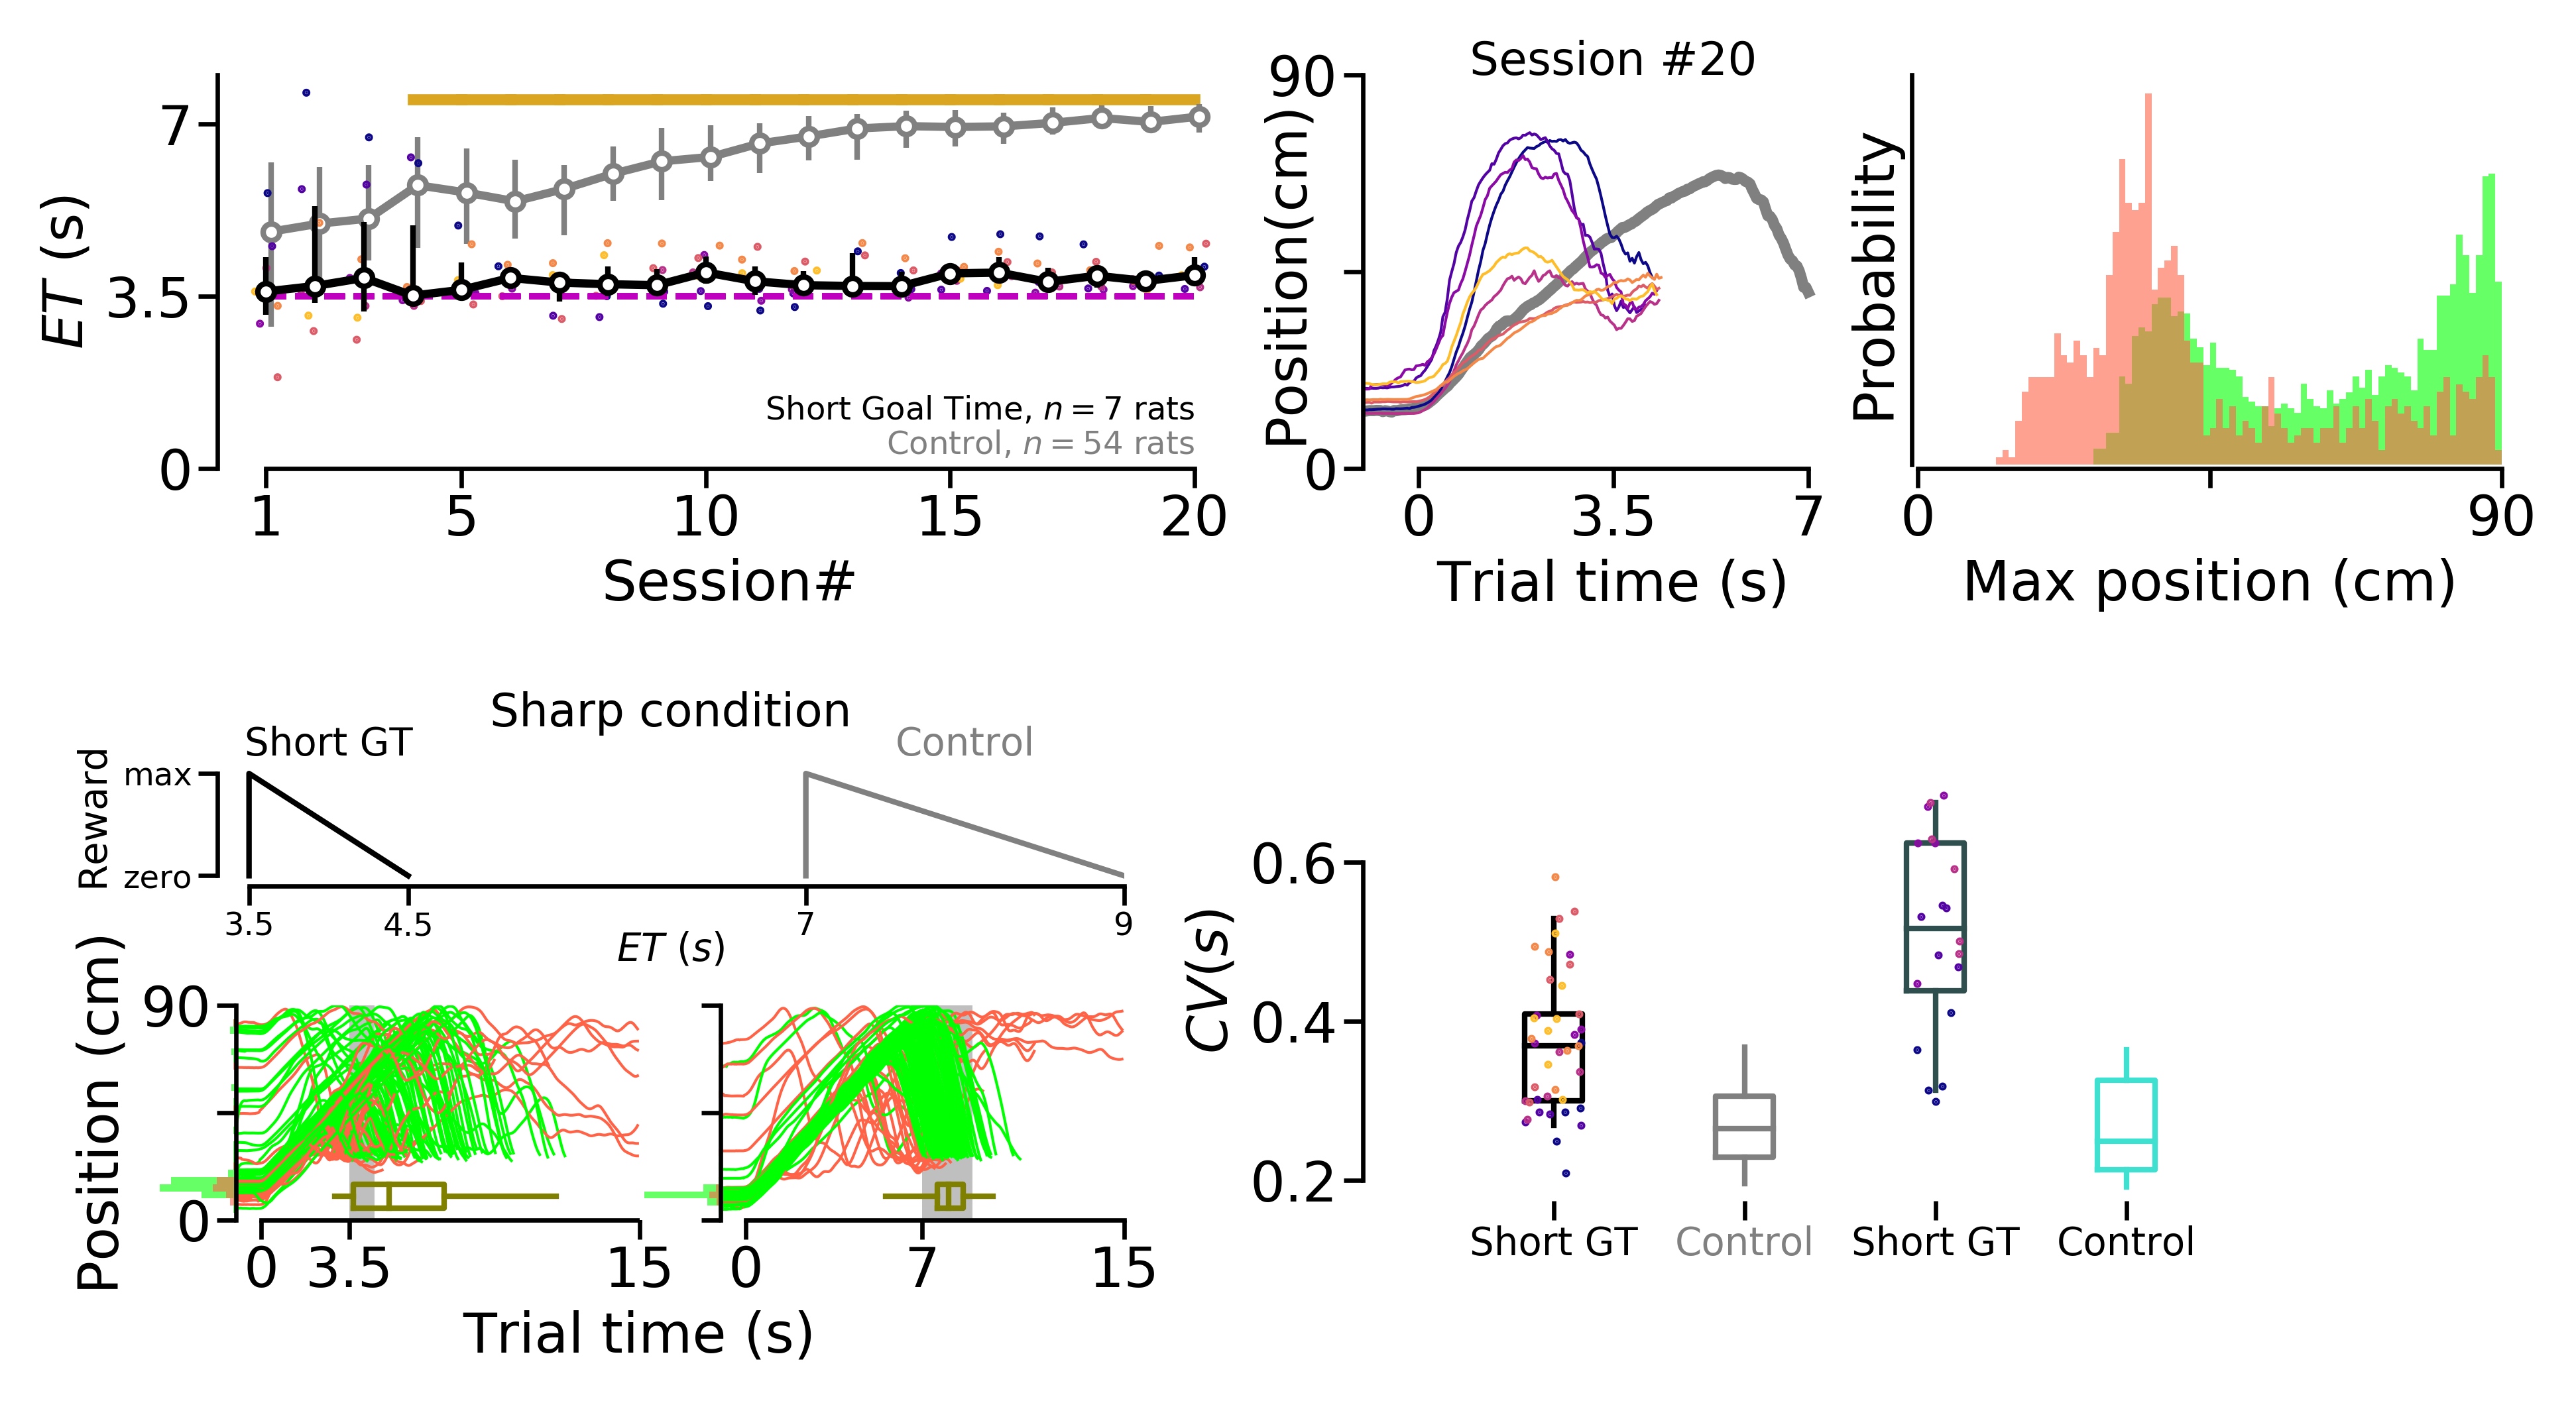

In [24]:
if "__file__" not in dir():
    plt.close('all')
    set_rc_params()
    figsize=(6,3)
    fig=plt.figure(figsize=figsize,dpi=600)
        

    ##########################################
    # 1: learning curve ShortGT
    gs1= fig.add_gridspec(nrows=1, ncols=1, left=0.02, bottom=0.65, right=0.45, top=0.98)
    ax1= fig.add_subplot(gs1[0])
    
    D3_1=plot_dotted_learning_curve(ax1, root, animalList1, profile1, TaskParamToPlot1, stop_dayPlot1,colors1)
    D3_2=plot_learning_curve(ax1, root, animalList1Ctrl, profile1Ctrl, TaskParamToPlot1, stop_dayPlot1)
    permTest1=TwoTailPermTest(group1=D3_1, group2=D3_2, nIterations=10000)
    permTest1.plotSignificant(ax=ax1,y=7.5,color=colorSig1,lw=2)
    s=f'{label1}, $n={len(animalList1)}$ rats'
    ax1.text(x=stop_dayPlot1, y=1, s=s, fontsize='xx-small', zorder=5,ha='right',color='k')
    s=f'Control, $n={len(animalList1Ctrl)}$ rats'
    ax1.text(x=stop_dayPlot1, y=.3, s=s, fontsize='xx-small', zorder=5,ha='right',color=color1Ctrl)
    
    ax1.set_ylabel('$ET$ (s)')

    
    ###########################################
    # 2: average trajectory ShortGT
    gs2= fig.add_gridspec(nrows=1, ncols=1, left=0.50, bottom=0.65, right=0.71, top=0.98)
    ax2= fig.add_subplot(gs2[0])
    plot_median_trajectory(root,ax2, profile1, animalList1, stop_dayPlot1-1,colors1)
    plot_grand_average(root, ax2, profile1Ctrl, animalList1Ctrl, stop_dayPlot1-1, color=color1Ctrl,lw=2,zorder=-5)
    ax2.yaxis.set_label_coords(-0.1,0.5)
        
        

    ###########################################
    # 3: Max position prob
    gs3= fig.add_gridspec(nrows=1, ncols=1, left=0.73, bottom=0.65, right=0.98, top=0.98)
    ax3= fig.add_subplot(gs3[0])
    plot_prob_max_pos(ax3, animalList1, profile1, sessionRange3, trdBins3)        

    
    
    ###########################################
    # 4: Sharp Condition DEF
    gs4= fig.add_gridspec(nrows=1, ncols=1, left=0.02, bottom=0.30, right=0.40, top=0.42)
    ax4= fig.add_subplot(gs4[0])
    
    plot_sharp_definition(ax4)


    ###########################################
    # 5: plot example trajectories 
    gs5= fig.add_gridspec(nrows=1, ncols=2, left=-0.006, bottom=0.02, right=0.40, top=0.20, wspace=wspace5)
    ax5Short= fig.add_subplot(gs5[0])
    ax5Ctrl = fig.add_subplot(gs5[1])
    
    plot_trajectories_and_ET_dist(root, ax5Short, sessionShortGTSharp5)
    plot_trajectories_and_ET_dist(root, ax5Ctrl, sessionCtrlSharp5)
    ax5Ctrl.set_ylabel('')
    ax5Ctrl.set_yticklabels([])
    ax5Ctrl.set_xlabel('')
    ax5Short.set_xlabel('')
    
    totAx5=fig.add_subplot(gs5[:],frameon=False)
    totAx5.set_xlabel('Trial time (s)')
    totAx5.yaxis.set_visible(False)
    totAx5.set_xlim([0,10])
    totAx5.set_yticks([5])
    totAx5.tick_params(color=(0, 0, 0, 0),labelcolor=(0, 0, 0, 0),zorder=-10)

    
    ###########################################
    # 6: Sharp CV Compare
    gs6= fig.add_gridspec(nrows=1, ncols=1, left=0.50, bottom=0.02, right=0.90, top=0.42)
    ax6= fig.add_subplot(gs6[0])
    
    
    plot_CV_boxplot(root,ax6,
                        profile1,animalList1,sessionRange3,
                        profile1Ctrl,animalList1Ctrl,sessionRange3Ctrl,
                        profile6S,animalList1,sessionRange6S,
                        profileCtrl6S,animalListCtrl6S,sessionRangeCtrl6S,
                        labels6, colors1)
    
#     permTest6=TwoTailPermTest(group1=dataPool6, group2=CdataPool6, nIterations=10000)
#     permTest6.plotSignificant(ax=ax6,y=.6,color=colorSig1,lw=2)
#     if permTest6.significantDiff[0]:
#         ax6.plot([1,2],[ax6.get_ylim()[1]*.95,ax6.get_ylim()[1]*.95],
#                 solid_capstyle='projecting',color=colorSig1,lw=2,zorder=0)

   
    

#     ###########################################
#     # 8: average trajectory NTO
#     gs8= fig.add_gridspec(nrows=1, ncols=1, left=0.66, bottom=0.0, right=0.81, top=0.38)
#     ax8NTO= fig.add_subplot(gs8[0])
#     plot_median_trajectory(root,ax8NTO, profile4NTO, animalList4NTO, stop_dayPlot3-1,colors4NTO)
#     plot_grand_average(root, ax8NTO, profile3Ctrl, animalList3Ctrl, stop_dayPlot3-1, color=color3Ctrl,lw=2,zorder=-5)

        
    
    
    
    ###########################################
    # 9: probabblity of initial pos
    
    
    

#     #############################################
#     #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#     AXES=(axes3[0],ax1,ax2,axes7[0],ax5,ax6)
#     OFFX=(.05,)*len(AXES)
#     OFFY=(.03,)*len(AXES)
#     add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)


    fig.savefig(os.path.join(os.path.dirname(os.getcwd()),'BehavioralPaper','Figures','ShortGT-SharpTrd.pdf'),
                format='pdf', bbox_inches='tight')
    
    plt.show()
    plt.close('all')
    matplotlib.rcdefaults()